#### 1. Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.stats import norm
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#### 2. Paths & Data Loading

In [6]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_3"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(15, 3), y:(15,)


#### 3. Add Weekly Data

In [7]:
# --- Weekly results ---
week_data = [
    (np.array([0.94995968, 0.98491081, 0.40447853]), -0.04185694811542118),  # W1
    (np.array([0.741774, 0.823083, 0.500825]),   -0.028695780761497047), # W2
    (np.array([0.250686, 0.415794, 0.535793]),  -0.016962989500793044), # W3
    (np.array([0.009132, 0.751348, 0.001341]),  -0.10619019401261509), # W4
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(19, 3), y:(19,)


#### 4. Quick Visualization

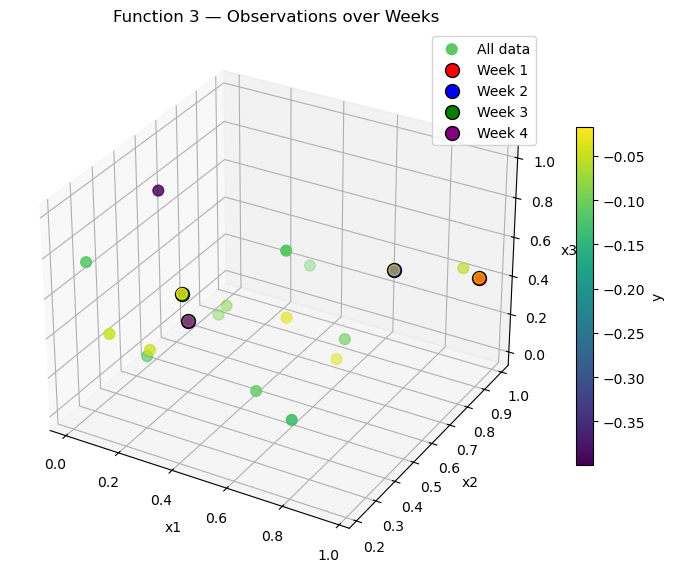

In [8]:
# --- Visualisation (3D projection: x1-x2-x3) ---

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

# puntos iniciales coloreados por y
p = ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap='viridis', s=60, label='All data')

# marcar semanas con colores distintos
ax.scatter(*week_data[0][0], c='red', s=100, edgecolors='k', label='Week 1')
ax.scatter(*week_data[1][0], c='blue', s=100, edgecolors='k', label='Week 2')
ax.scatter(*week_data[2][0], c='green', s=100, edgecolors='k', label='Week 3')
ax.scatter(*week_data[3][0], c='purple', s=100, edgecolors='k', label='Week 4')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Function 3 — Observations over Weeks')
fig.colorbar(p, ax=ax, shrink=0.6, label='y')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model


In [9]:
# Week 3: use tighter length_scale bounds (0.05-2.0) to prevent extreme smoothing.
# Noise term slightly increased (0.03) to reflect observed variance in y.

kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=[0.3, 0.3, 0.3], nu=2.5, length_scale_bounds=(0.05, 2.0))
    + WhiteKernel(noise_level=0.03, noise_level_bounds=(1e-4, 0.5))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=20,
    random_state=0
)
gp.fit(X, y)
print("[F3] Fitted kernel (fit #1):", gp.kernel_)

[F3] Fitted kernel (fit #1): 1.15**2 * Matern(length_scale=[2, 2, 0.0735], nu=2.5) + WhiteKernel(noise_level=0.0113)


#### 5.2 Model Diagnostics and Refit


In [11]:
# --- Diagnostics: check if any length_scale is stuck at its bound ---
try:
    matern = gp.kernel_.k1.k2
    lscales = np.atleast_1d(matern.length_scale)
    lb, ub = matern.length_scale_bounds
    at_lower = np.isclose(lscales, lb, atol=1e-3).any()
    at_upper = np.isclose(lscales, ub, atol=1e-3).any()
except Exception as e:
    at_lower = at_upper = False

# If optimizer hit boundary, refit with relaxed bounds
if at_lower or at_upper:
    print("[F3][WARN] length_scale reached boundary → refitting with wider bounds...")
    kernel_refit = (
        C(1.0, (1e-3, 1e3)) *
        Matern(length_scale=lscales, nu=2.5, length_scale_bounds=(1e-3, 3.0))
        + WhiteKernel(noise_level=0.03, noise_level_bounds=(1e-4, 0.5))
    )
    gp = GaussianProcessRegressor(
        kernel=kernel_refit,
        normalize_y=True,
        n_restarts_optimizer=25,
        random_state=1
    )
    gp.fit(X, y)
    print("[F3] Re-fitted kernel (fit #2):", gp.kernel_)

# --- Best observed point (incumbent) ---
best_idx = np.argmax(y)
x_best, y_best = X[best_idx], y[best_idx]
print(f"[F3] Best observed → x={x_best}, y_best={y_best:.6f}")

[F3][WARN] length_scale reached boundary → refitting with wider bounds...
[F3] Re-fitted kernel (fit #2): 1.21**2 * Matern(length_scale=[3, 3, 0.0797], nu=2.5) + WhiteKernel(noise_level=0.015)
[F3] Best observed → x=[0.250686 0.415794 0.535793], y_best=-0.016963


#### 5.3 Acquisition and Candidate Generation  

In [12]:
#### 5.3 Acquisition and Candidate Generation

import numpy as np
from scipy.stats import norm

# --- Helpers ---
def lhs(lb, ub, n, seed=0):
    """Latin Hypercube-like uniform sampler (simple RNG version)."""
    rng = np.random.default_rng(seed)
    U = rng.random((n, lb.size))
    return lb + U * (ub - lb)

def too_close_Linf(c, X, tol=0.02):
    """Reject if candidate is within L_inf < tol to any existing point."""
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# --- Bounds: observed range + 10% padding, clipped to [0,1] ---
lo, hi = X.min(axis=0), X.max(axis=0)
pad = 0.10
lb = np.clip(lo - pad * (hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad * (hi - lo), 0.0, 1.0)

# --- Trust region anchored at BEST observed (not the latest) ---
anchor = X[np.argmax(y)]   # CHANGED: was week_data[-1][0]
L = 0.30                   # TR width (relative box size)
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0.0, 1.0)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0.0, 1.0)
print("[F3] TR anchor (best observed):", anchor)

# --- Candidates: 70% TR + 30% global ---
N_tr, N_gl = 28000, 12000
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=3101)
C_gl = lhs(lb,    ub,    N_gl, seed=3102)
Cands = np.vstack([C_tr, C_gl])

# --- GP prediction ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- Expected Improvement (EI), mild exploitation ---
y_best = y.max()   # incumbent in original scale
xi = 0.02
improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- Anti-edge mask (avoid candidates too close to borders) ---
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# --- Pick best non-duplicate candidate (EI first; fallback UCB → MaxVar) ---
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.02):
        x_next = cand
        break

if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    # Fallback 1: UCB
    kappa = 1.4
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.02):
            x_next = cand
            chosen = "UCB"
            break

if x_next is None:
    # Fallback 2: Maximum variance (pure exploration)
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.02):
            x_next = cand
            chosen = "MaxVar"
            break

# --- Output ---
print(f"[F3] Chosen by {chosen}: {x_next}")
print("Submission format:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# --- Quick sanity checks ---
print("Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("Near-duplicate (L_inf < 0.02)? ", too_close_Linf(x_next, X, tol=0.02))

[F3] TR anchor (best observed): [0.250686 0.415794 0.535793]
[F3] Chosen by EI: [0.94109307 0.9006683  0.85641765]
Submission format:
0.941093 - 0.900668 - 0.856418
Within [0,1]?  True
Near-duplicate (L_inf < 0.02)?  False


## Reflection — Function 3


### Week 1
- Initial model showed highly negative outputs (≈ -0.04), suggesting the function surface was mostly below zero.  
- The GP was set up with broad Matern ν = 2.5 and noise term to manage variability.  
- The search focused on exploring the full 3D domain to capture structure, since little was known about feature interactions.  
- Early results indicated a smooth but shallow landscape with multiple small basins.

---

### Week 2
- The second query improved slightly (-0.04 → -0.028), confirming the GP was moving in the right direction.  
- The kernel length scales began stabilising around ~0.3-0.5, indicating moderate correlation between features.  
- Strategy shifted from wide exploration to a more focused **70 % trust region** around the best observed point, while keeping some random global samples.  
- A smaller ξ = 0.02 was introduced to promote exploitation after early gains.

---

### Week 3
- Continued improvement (-0.028 → -0.017) suggested convergence toward a local optimum.  
- The updated GP used tighter bounds `(0.05, 2.0)` and higher noise (0.03) to stay numerically stable.  
- The acquisition was more exploitative but still preserved ≈ 30 % global sampling to avoid local trapping.  
- Next steps: narrow the trust region (L ≈ 0.25), test smaller ξ (≈ 0.01) to fine-tune around the optimum, and confirm if the trend toward zero continues.

### Reflection — Function 3 (Week 4 → Week 5)

- **Outcome (W4):** Performance regressed (−0.106), breaking the W1→W3 improving trend (−0.042 → −0.017). That suggested we stepped off the gentle ridge found around W3.
- **Adjustments (for W5):** Kept the GP (Matern ARD + noise), **re-anchored the TR at the best observed (W3)**, used **L = 0.30**, **70% TR / 30% global**, and **EI with ξ = 0.02** to balance local refinement with modest exploration.
- **Selected query (W5):** `0.941093 - 0.900668 - 0.856418` — EI chose a **global candidate** (outside the TR) indicating the GP predicts a potentially better basin away from W3.
- **Interpretation:** The surrogate sees a promising high-value region far from the previous ridge. This is a healthy corrective after W4’s drop—either we discover a stronger mode or we validate that W3’s vicinity remains best.
- **Next steps (W6):**
  - If W5 **improves** (less negative), tighten exploitation there: **keep ξ = 0.02 → 0.015**, reduce **L to 0.25**, and raise TR share to **75%**.
  - If W5 **does not improve**, revert anchor to **W3**, keep **ξ = 0.02**, and slightly widen TR (**L = 0.35**) to sweep the local ridge before trying another global hop.

**Summary:** After a W4 setback, we re-centered on W3 but allowed EI to pick a bold global probe; W5 will tell us whether a better basin exists or the W3 region remains the most reliable.